In [72]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
import time
from collections import Counter
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
#bbox_to_anchor =(1.0, 1.0)
import requests
save_path= '/Users/johgeist/Documents/AG_Luck/3did_project/revisions/revision_figures/'

In [2]:
# Function to count rows in a group
def count_rows(group):
    return group.shape[0]

# Function to retrieve domain residues from Chain1/2Iface columns derived from 3did
def retrieve_domain_residue_nos(string):
    resi_nos = set()
    for i in string.split(','):
        pre_resi = i.split(':')[1]
        resi = ''
        for l in pre_resi:
            if l in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-']:
                resi += l
        resi_nos.add(int(resi))
    return resi_nos

# Function to retrieve domain boundaries given for each CATH domain in each PDB structure
# (derived from the CATH database)

def retrieve_domain_boundaries(string):
    if pd.isna(string):
        domain_bound = np.NaN
    else:
        domain_bounds = []
        for i in string.split(','):
            domain_bound_t = i.split(':')[0]
            domain_bounds.append(domain_bound_t)
        domain_bound = ', '.join(domain_bounds)
    return domain_bound


# Function to check whether CATH domain and Pfam domain overlap for a given PDB ID and chain
def check_range(row,col1,col2,col3):
    if pd.isna(row[col1]):
        return np.NaN
    else:
        n_matches = 0
        for interval in row[col1].split(','):
            pre_range = interval.split('-')
            if len(pre_range) > 2:
                cath_range= pre_range[1:]
                cath_range[0] = '-' + cath_range[0]
            else:
                cath_range = pre_range
            cath_lower = int(cath_range[0])
            cath_upper = int(cath_range[1])
            if any(cath_lower <= elem <= cath_upper for elem in row[col2]):
                n_matches += 1
        if n_matches > 0:
            return row[col3]
        else:
            return 'No match'
        
# Function to check if a set contains at least one non-NaN, non-'No match' element
def contains_non_nan_non_no_match(s):
    return any(elem not in {np.nan, 'No match'} for elem in s)

# Function to generate a custom autopunct
def make_autopct(data):
    def my_autopct(pct):
        total = sum(data)
        val = int(round(pct*total/100.0))
        if val/total < 0.1:
            return ' '
        else:
            return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

# Define a function to filter out NaN and 'No match'
def filter_nan_no_match(s):
    return {x for x in s if pd.notna(x) and x != 'No match'}


# Function to count unique elements
def count_unique(x):
    return x.nunique()

In [3]:
# Connect to the MySQL database and read the preprocessed 3did into a DataFrame
eng = sqlalchemy.create_engine('mysql://', creator= db_utils.get_connection)
query= pd.read_sql_query('''select * from chopyan_db.3did_agg_DDI_PDB as df''', con= eng)
DDI_CS = pd.DataFrame(query)
DDI_CS

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,DomainStart2,DomainEnd2,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain
0,PF00001_PF00001,1gzm,A,PF00001,7tm_1,54,306,B,PF00001,7tm_1,54,306,26.18,7.82923,"E:196,E:196,E:196,E:196,E:197,N:199,E:201,E:20...","F:228,K:231,E:232,A:233,E:232,F:228,V:227,F:22...",1
1,PF00001_PF00001,1hzx,B,PF00001,7tm_1,54,246,B,PF00001,7tm_1,224,306,42.49,7.03413,"I:54,I:54,I:54,N:55,N:55,N:55,T:58,L:72,L:72,L...","V:300,P:303,V:304,A:299,V:300,P:303,Y:306,V:25...",0
2,PF00001_PF00001,1l9h,B,PF00001,7tm_1,54,246,B,PF00001,7tm_1,224,306,40.17,9.39410,"I:54,I:54,N:55,N:55,N:55,T:58,L:72,L:72,L:72,L...","V:300,P:303,A:299,V:300,P:303,Y:306,V:250,M:25...",0
3,PF00001_PF00001,2j4y,A,PF00001,7tm_1,54,306,B,PF00001,7tm_1,54,306,26.85,6.86878,"N:199,E:201,E:201,E:201,S:202,S:202,I:205,V:20...","Q:236,F:228,K:231,E:232,F:228,E:232,F:228,F:22...",1
4,PF00001_PF00001,2vt4,C,PF00001,7tm_1,58,343,D,PF00001,7tm_1,58,343,20.02,6.36751,"L:152,V:160,T:164,T:164,A:167,I:168,I:168,A:17...","F:315,A:206,A:206,A:210,W:181,A:210,I:214,W:18...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235443,PF18841_PF17433,1wmr,A,PF18841,B_solenoid_dext,321,354,A,PF17433,Glyco_hydro_49N,19,184,9.52,4.52235,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235444,PF18841_PF17433,1x0c,B,PF18841,B_solenoid_dext,321,354,B,PF17433,Glyco_hydro_49N,19,184,9.52,4.45403,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235445,PF18841_PF17433,2z8g,A,PF18841,B_solenoid_dext,321,354,A,PF17433,Glyco_hydro_49N,19,184,9.24,4.49346,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235446,PF18841_PF17433,3wwg,C,PF18841,B_solenoid_dext,321,354,C,PF17433,Glyco_hydro_49N,19,184,9.24,4.61412,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0


In [4]:
DDI_CS['PDB_ID']= DDI_CS['PDB_ID'].str.upper()

In [5]:
# Add another column counting residue-residue contactcs of an interface,
# check whether the # ofcontacts are the same for both domains
contacts1 = []
for i in DDI_CS['Chain1Iface']:
    contacts1.append(len(i.split(',')))
DDI_CS['contacts1'] = contacts1
contacts2 = []
for i in DDI_CS['Chain2Iface']:
    contacts2.append(len(i.split(',')))
DDI_CS['contacts2'] = contacts2
DDI_CS[(DDI_CS['contacts1'] != DDI_CS['contacts2'])]

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,DomainStart2,DomainEnd2,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,contacts2


In [6]:
DDI_CS = DDI_CS.drop(columns= ['contacts2'])

In [7]:
# Merge DDI_CS with additional protein information
df_protein_info = pd.read_csv('/Users/johgeist/Downloads/DDI_type_structure_level_interchain_homo_protein_whole_3did.csv', index_col=0)
df_protein_info= df_protein_info.drop(columns=['IsInterchain', 'Chain1', 'Chain2'])
DDI_CS= pd.merge(DDI_CS, df_protein_info, on=['DDI_type', 'PDB_ID'])

In [8]:
# Drop rows that relate to intrachain or homodimeric interfaces
DDI_inter= DDI_CS.drop(index= DDI_CS[DDI_CS['isInterchain'] == 0].index)
DDI_inter_hetero = DDI_inter.drop(index= DDI_inter[DDI_inter['HomoProtein'] == 1].index)

In [9]:
#DDI_inter_hetero.to_csv('/Users/johgeist/Downloads/3did_project_dataframes_new/3did_metrics_inter_hetero_subset_structure_level.csv', index=False)

In [10]:
# Select one interface per DDI type as well as its metrics based on the highest 3did score
df_index_max_Score = DDI_inter_hetero.groupby('DDI_type').agg({'Score': 'idxmax'})
DDI_inter_hetero_grouped_max_Score = DDI_inter_hetero[DDI_inter_hetero.index.isin(df_index_max_Score.Score.tolist())]

In [11]:
DDI_inter_hetero_grouped_max_Score

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,HomoDDI,UniProt1,UniProt2,HomoProtein
72,PF00001_PF00048,5UIW,A,PF00001,7tm_1,47,297,B,PF00048,IL8,...,13.26,5.101720,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",1,51,0,"P51681,P00268",P13501,0
82,PF00001_PF00085,6H7O,B,PF00001,7tm_1,58,343,F,PF00085,Thioredoxin,...,1.57,1.963520,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",1,7,0,P07700,P0AA25,0
84,PF00001_PF00087,6WJC,A,PF00001,7tm_1,42,418,C,PF00087,Toxin_TOLIP,...,15.76,5.828060,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",1,44,0,"P11229,D9IEF7",Q8QGR0,0
85,PF00001_PF00322,5GLH,A,PF00001,7tm_1,107,387,B,PF00322,Endothelin,...,31.19,7.365980,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",1,78,0,"P00720,P24530",P05305,0
92,PF00001_PF00339,6TKO,A,PF00001,7tm_1,58,343,B,PF00339,Arrestin_N,...,18.24,5.657100,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",1,38,0,P07700,P49407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235247,PF18782_PF00559,6NIL,A,PF18782,NAD2,193,372,C,PF00559,Vif,...,7.74,3.639300,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",1,23,0,Q8IUX4,P12504,0
235281,PF18784_PF00071,3NBZ,D,PF18784,CRM1_repeat_2,405,472,F,PF00071,Ras,...,8.76,4.306780,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",1,25,0,Q6P5F9,P62826,0
235371,PF18801_PF00072,3Q15,A,PF18801,RapH_N,4,65,C,PF00072,Response_reg,...,10.48,4.961570,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",1,22,0,Q59HN8,P06628,0
235372,PF18806_PF00071,2X19,B,PF18806,Importin_rep_3,826,900,A,PF00071,Ras,...,0.05,0.237612,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",1,7,0,O94829,P32835,0


In [12]:
# Check whether there are NaN values for the UniProt IDs (from the protein information df)
DDI_inter_hetero_grouped_max_Score[(DDI_inter_hetero_grouped_max_Score['UniProt1']== 'No UniProt') & (DDI_inter_hetero_grouped_max_Score['UniProt2']== 'No UniProt')]

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,HomoDDI,UniProt1,UniProt2,HomoProtein


In [13]:
# Keep only those columns that are necessary for further analysis, DDI_type is the unique idendifier for each DDI
# PDB ID of the structure with the highest 3did score is needed later for merging with ProtCID data
DDI_inter_hetero_grouped_max_Score = DDI_inter_hetero_grouped_max_Score.filter(['DDI_type', 'Score', 'Zscore',
'contacts1', 'PDB_ID', 'Chain1Iface', 'Chain2Iface', 'Chain_ID1', 'Chain_ID2'])

In [14]:
DDI_inter_hetero_grouped_max_Score

,DDI_type,Score,Zscore,contacts1,PDB_ID,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2
72,PF00001_PF00048,13.26,5.101720,51,5UIW,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",A,B
82,PF00001_PF00085,1.57,1.963520,7,6H7O,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",B,F
84,PF00001_PF00087,15.76,5.828060,44,6WJC,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",A,C
85,PF00001_PF00322,31.19,7.365980,78,5GLH,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",A,B
92,PF00001_PF00339,18.24,5.657100,38,6TKO,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",A,B
...,...,...,...,...,...,...,...,...,...
235247,PF18782_PF00559,7.74,3.639300,23,6NIL,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",A,C
235281,PF18784_PF00071,8.76,4.306780,25,3NBZ,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",D,F
235371,PF18801_PF00072,10.48,4.961570,22,3Q15,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",A,C
235372,PF18806_PF00071,0.05,0.237612,7,2X19,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",B,A


In [15]:
DDI_inter_hetero_grouped_max_Score.rename({'PDB_ID': 'PDB_ID_max'}, inplace=True, axis=1)

In [16]:
# DDI_merged combines DDI_inter_hetero_grouped_max_Score with additional data from DDI_CS, that can only be inferred 
# from there (# inter-/ intrachain structures etc.) or aid further annottation of the DDI
DDI_merged = pd.merge(DDI_CS.groupby('DDI_type').agg({'DomainID1': 'first','DomainID2': 'first',
                                                      'DomainName1': 'first','DomainName2': 'first',
                                                      'PDB_ID': count_rows,
                                                      'isInterchain': sum}).reset_index(),
                                                          DDI_inter_hetero_grouped_max_Score,
                                                        on='DDI_type', how= 'inner')

In [17]:
DDI_merged.rename({'PDB_ID': 'Num_structures', 'isInterchain': 'Num_interchain_structures',
                   'HomoProtein': 'Num_homo_protein_structures', 'HomoDDI': 'Homo_DDI'}, inplace=True, axis=1)
DDI_merged['Interchain_fraction'] = DDI_merged['Num_interchain_structures']/DDI_merged['Num_structures']
DDI_merged['Num_intrachain_structures']= DDI_merged['Num_structures']-DDI_merged['Num_interchain_structures']

In [18]:
DDI_merged

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Num_structures,Num_interchain_structures,Score,Zscore,contacts1,PDB_ID_max,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2,Interchain_fraction,Num_intrachain_structures
0,PF00001_PF00048,PF00001,PF00048,7tm_1,IL8,8,8,13.26,5.101720,51,5UIW,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",A,B,1.000000,0
1,PF00001_PF00085,PF00001,PF00085,7tm_1,Thioredoxin,7,6,1.57,1.963520,7,6H7O,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",B,F,0.857143,1
2,PF00001_PF00087,PF00001,PF00087,7tm_1,Toxin_TOLIP,1,1,15.76,5.828060,44,6WJC,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",A,C,1.000000,0
3,PF00001_PF00322,PF00001,PF00322,7tm_1,Endothelin,4,4,31.19,7.365980,78,5GLH,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",A,B,1.000000,0
4,PF00001_PF00339,PF00001,PF00339,7tm_1,Arrestin_N,6,3,18.24,5.657100,38,6TKO,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",A,B,0.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,PF18782_PF00559,PF18782,PF00559,NAD2,Vif,1,1,7.74,3.639300,23,6NIL,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",A,C,1.000000,0
5720,PF18784_PF00071,PF18784,PF00071,CRM1_repeat_2,Ras,34,34,8.76,4.306780,25,3NBZ,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",D,F,1.000000,0
5721,PF18801_PF00072,PF18801,PF00072,RapH_N,Response_reg,1,1,10.48,4.961570,22,3Q15,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",A,C,1.000000,0
5722,PF18806_PF00071,PF18806,PF00071,Importin_rep_3,Ras,1,1,0.05,0.237612,7,2X19,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",B,A,1.000000,0


In [19]:
# Read in manual curation dataset as a DataFrame and merge with the original 3did DataFrame (DDI_CS) to get the
# respective 3did score for all interfaces 
# select the rows relating to the structure with the interface with the highest 3did score (same as before)
# for a Pfam-Pfam combination
df_mc = pd.read_csv('/Users/johgeist/Downloads/DDI_curation table_wihtout_homo_protein_structures_4.csv')
df_mc = df_mc[~df_mc['DDI_type'].str.contains('curation')]
df_mc['PDB_ID'] = df_mc['PDB_ID'].str.upper()

In [20]:
df_Score = pd.merge(DDI_CS, df_mc, on= ['DDI_type', 'PDB_ID'], how = 'inner')
df_Score

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,ProtCID_cluster_approved,Motif_binding_domain_present,Motif_binding_domain,DMI_overlap_checked,DMI_overlap_identified,DDI_approved,Curator,Comments,non-approved category,Unnamed: 19
0,PF00004_PF10584,6EPF,I,PF00004,AAA,222,355,C,PF10584,Proteasome_A_N,...,1.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",1 out of 1 supporting CS showed an interchain ...,HMM (at least one Pfam has unfolded structure),linear stretch within domain
1,PF00009_PF01873,2D74,A,PF00009,GTP_EFTU,9,201,B,PF01873,eIF-5_eIF-2B,...,0.0,0.0,NaN,NaN,NaN,1.0,JG,11 out of 11 supporting CS showed interchain i...,NaN,NaN
2,PF00010_PF02344,1NKP,B,PF00010,HLH,203,254,D,PF02344,Myc-LZ,...,0.0,0.0,NaN,NaN,NaN,0.0,JG,Second structure checked for PF00010_PF02344. ...,NaN,NaN
3,PF00010_PF02344,6G6L,B,PF00010,HLH,214,254,C,PF02344,Myc-LZ,...,0.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",2 out of 6 supporting structures in 3did showe...,crystal contact,NaN
4,PF00019_PF00041,4UI2,B,PF00019,TGF_beta,294,395,A,PF00041,fn3,...,NaN,0.0,NaN,NaN,NaN,0.0,JG,Only 1 supporting CS was present for the DDI t...,crystal contact,study describes crystal contact interface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,PF17292_PF08644,4KHB,H,PF17292,POB3_N,5,97,G,PF08644,SPT16,...,1.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",3 out of 3 supporting CS displayed interchain ...,contact is minimal,NaN
91,PF17292_PF08644,6UPK,H,PF17292,POB3_N,5,99,G,PF08644,SPT16,...,1.0,0.0,NaN,NaN,NaN,0.0,JG,Second structure checked for PF17292_PF08644. ...,NaN,NaN
92,PF17820_PF16523,3L4F,D,PF17820,PDZ_6,701,755,A,PF16523,betaPIX_CC,...,NaN,0.0,NaN,NaN,NaN,0.0,"JG, JL",Only one structure supporting the DDI type (Sc...,HMM (at least one Pfam has unfolded structure),motif is C-terminally included in the Pfam match
93,PF17838_PF00071,3KZ1,B,PF17838,PH_16,950,1079,E,PF00071,Ras,...,0.0,0.0,NaN,NaN,NaN,1.0,JG,9 out of 9 supporting CS displayed interchain ...,NaN,NaN


In [21]:
# Group the dataframe to get a 3did score for each DDI type based on the interface in the 3D structure with
# the highest score for the DDI interface in 3did
df_Score_index = df_Score.groupby('DDI_type').agg({'Score': 'idxmax'})
df_Score_max = df_Score[df_Score.index.isin(df_Score_index.Score.tolist())]

In [22]:
df_Score_max = df_Score_max.filter(['DDI_type', 'Score', 'PDB_ID'])
df_Score_max

,DDI_type,Score,PDB_ID
0,PF00004_PF10584,3.28,6EPF
1,PF00009_PF01873,9.54,2D74
3,PF00010_PF02344,3.30,6G6L
4,PF00019_PF00041,4.56,4UI2
5,PF00023_PF07686,1.25,4NIK
...,...,...,...
88,PF16004_PF00400,9.03,6ID0
90,PF17292_PF08644,2.26,4KHB
92,PF17820_PF16523,3.24,3L4F
93,PF17838_PF00071,14.92,3KZ1


In [23]:
# Filter DDI_merged holding all 3did information on a specific DDI interface in a specific 3D structure per row for
# for those associated with the DDIs of the manual curation set in their respective highest scoring 3D structures from
# df_Score_max
iface_mc = pd.merge(DDI_merged, df_Score_max.filter(['DDI_type']), on='DDI_type', how= 'inner')

In [24]:
iface_mc

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Num_structures,Num_interchain_structures,Score,Zscore,contacts1,PDB_ID_max,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2,Interchain_fraction,Num_intrachain_structures
0,PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,1,1,3.28,2.97548,8,6EPF,"G:226,P:227,N:332,R:333,R:333,R:333,R:333,E:335","E:15,E:15,R:17,S:13,E:15,Y:19,Y:23,P:14",I,C,1.000000,0
1,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,11,11,9.54,3.91978,32,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",A,B,1.000000,0
2,PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,6,2,3.30,3.27272,16,6G6L,"S:224,R:226,D:227,D:227,D:227,D:227,S:228,P:23...","K:959,S:962,Q:958,K:959,S:962,E:963,Q:958,Q:95...",B,C,0.333333,4
3,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,1,1,4.56,2.98602,18,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",B,A,1.000000,0
4,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1,1,1.25,1.80728,7,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",A,B,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,PF16004_PF00400,PF16004,PF00400,EFTUD2,WD40,10,10,9.03,4.76148,24,6ID0,"Y:73,Y:73,V:77,V:77,V:77,V:77,E:78,E:78,E:78,T...","L:196,V:199,L:196,Y:197,R:198,V:199,Y:197,R:19...",C,T,1.000000,0
76,PF17292_PF08644,PF17292,PF08644,POB3_N,SPT16,3,3,2.26,2.49544,8,4KHB,"L:14,L:14,S:52,R:53,A:55,E:59,Q:71,Q:71","M:561,G:562,R:563,R:563,G:562,R:563,M:561,G:562",H,G,1.000000,0
77,PF17820_PF16523,PF17820,PF16523,PDZ_6,betaPIX_CC,1,1,3.24,2.33869,6,3L4F,"Y:701,H:735,H:735,H:735,V:739,R:743","W:641,D:642,E:643,T:644,T:644,N:645",D,A,1.000000,0
78,PF17838_PF00071,PF17838,PF00071,PH_16,Ras,9,9,14.92,5.86783,27,3KZ1,"K:978,L:1032,L:1032,R:1034,R:1034,S:1035,V:103...","D:76,V:38,L:69,F:39,E:40,N:41,N:41,N:41,Y:42,V...",B,E,1.000000,0


In [25]:
## Load in the newest CATH domain matches for the PDB and modify the dataframe for better readability
df2 = pd.read_csv('/Users/johgeist/Downloads/cath-b-newest-all', sep=' ', header=None)

In [26]:
df2

,0,1,2,3
0,101mA00,v4_3_0,1.10.490.10,0-153:A
1,102lA00,v4_3_0,1.10.530.40,1-162:A
2,102mA00,v4_3_0,1.10.490.10,0-153:A
3,103lA00,v4_3_0,1.10.530.40,1-162:A
4,103mA00,v4_3_0,1.10.490.10,0-153:A
...,...,...,...,...
536608,7cdvB02,putative,3.40.50.2300,"180-309:B,342-349:B"
536609,7cdxA01,putative,3.40.50.2300,"75-179:A,310-341:A"
536610,7cdxA02,putative,3.40.50.2300,"180-309:A,342-346:A"
536611,7cdxB01,putative,3.40.50.2300,"77-179:B,310-341:B"


In [27]:
df2.columns = ['PDBID_chain_domain-no', 'CATH_version', 'CATH_domain_ID', 'Domain_boundaries']

In [28]:
df2

,PDBID_chain_domain-no,CATH_version,CATH_domain_ID,Domain_boundaries
0,101mA00,v4_3_0,1.10.490.10,0-153:A
1,102lA00,v4_3_0,1.10.530.40,1-162:A
2,102mA00,v4_3_0,1.10.490.10,0-153:A
3,103lA00,v4_3_0,1.10.530.40,1-162:A
4,103mA00,v4_3_0,1.10.490.10,0-153:A
...,...,...,...,...
536608,7cdvB02,putative,3.40.50.2300,"180-309:B,342-349:B"
536609,7cdxA01,putative,3.40.50.2300,"75-179:A,310-341:A"
536610,7cdxA02,putative,3.40.50.2300,"180-309:A,342-346:A"
536611,7cdxB01,putative,3.40.50.2300,"77-179:B,310-341:B"


In [29]:
df2['PDB_ID']= df2['PDBID_chain_domain-no'].str[0:-3]
df2['PDB_ID'] = df2['PDB_ID'].str.upper()
df2['Chain']= df2['PDBID_chain_domain-no'].str[-3:-2]
df2['Domain_type_in_chain'] = df2['PDBID_chain_domain-no'].str[-2:]

In [30]:
df2

,PDBID_chain_domain-no,CATH_version,CATH_domain_ID,Domain_boundaries,PDB_ID,Chain,Domain_type_in_chain
0,101mA00,v4_3_0,1.10.490.10,0-153:A,101M,A,00
1,102lA00,v4_3_0,1.10.530.40,1-162:A,102L,A,00
2,102mA00,v4_3_0,1.10.490.10,0-153:A,102M,A,00
3,103lA00,v4_3_0,1.10.530.40,1-162:A,103L,A,00
4,103mA00,v4_3_0,1.10.490.10,0-153:A,103M,A,00
...,...,...,...,...,...,...,...
536608,7cdvB02,putative,3.40.50.2300,"180-309:B,342-349:B",7CDV,B,02
536609,7cdxA01,putative,3.40.50.2300,"75-179:A,310-341:A",7CDX,A,01
536610,7cdxA02,putative,3.40.50.2300,"180-309:A,342-346:A",7CDX,A,02
536611,7cdxB01,putative,3.40.50.2300,"77-179:B,310-341:B",7CDX,B,01


In [31]:
# Preprocessing of both dataframes (iface from 3did and df2 from CATH) for the necessary columns before idenitfying
# CATH matches in the 3did highest scoring structures
iface_mc_filt = iface_mc.filter(['DDI_type', 'DomainID1', 'DomainID2', 'DomainName1', 'DomainName2',
 'Score', 'Zscore', 'PDB_ID_max', 'Chain1Iface', 'Chain2Iface', 'Chain_ID1', 'Chain_ID2'])
df2_filt = df2.filter(['CATH_domain_ID', 'Domain_boundaries', 'PDB_ID', 'Chain', 'Domain_type_in_chain'])

In [32]:
iface_mc_filt

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Score,Zscore,PDB_ID_max,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2
0,PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,3.28,2.97548,6EPF,"G:226,P:227,N:332,R:333,R:333,R:333,R:333,E:335","E:15,E:15,R:17,S:13,E:15,Y:19,Y:23,P:14",I,C
1,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.91978,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",A,B
2,PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,3.30,3.27272,6G6L,"S:224,R:226,D:227,D:227,D:227,D:227,S:228,P:23...","K:959,S:962,Q:958,K:959,S:962,E:963,Q:958,Q:95...",B,C
3,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.98602,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",B,A
4,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.80728,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",A,B
...,...,...,...,...,...,...,...,...,...,...,...,...
75,PF16004_PF00400,PF16004,PF00400,EFTUD2,WD40,9.03,4.76148,6ID0,"Y:73,Y:73,V:77,V:77,V:77,V:77,E:78,E:78,E:78,T...","L:196,V:199,L:196,Y:197,R:198,V:199,Y:197,R:19...",C,T
76,PF17292_PF08644,PF17292,PF08644,POB3_N,SPT16,2.26,2.49544,4KHB,"L:14,L:14,S:52,R:53,A:55,E:59,Q:71,Q:71","M:561,G:562,R:563,R:563,G:562,R:563,M:561,G:562",H,G
77,PF17820_PF16523,PF17820,PF16523,PDZ_6,betaPIX_CC,3.24,2.33869,3L4F,"Y:701,H:735,H:735,H:735,V:739,R:743","W:641,D:642,E:643,T:644,T:644,N:645",D,A
78,PF17838_PF00071,PF17838,PF00071,PH_16,Ras,14.92,5.86783,3KZ1,"K:978,L:1032,L:1032,R:1034,R:1034,S:1035,V:103...","D:76,V:38,L:69,F:39,E:40,N:41,N:41,N:41,Y:42,V...",B,E


In [33]:
df2_filt

,CATH_domain_ID,Domain_boundaries,PDB_ID,Chain,Domain_type_in_chain
0,1.10.490.10,0-153:A,101M,A,00
1,1.10.530.40,1-162:A,102L,A,00
2,1.10.490.10,0-153:A,102M,A,00
3,1.10.530.40,1-162:A,103L,A,00
4,1.10.490.10,0-153:A,103M,A,00
...,...,...,...,...,...
536608,3.40.50.2300,"180-309:B,342-349:B",7CDV,B,02
536609,3.40.50.2300,"75-179:A,310-341:A",7CDX,A,01
536610,3.40.50.2300,"180-309:A,342-346:A",7CDX,A,02
536611,3.40.50.2300,"77-179:B,310-341:B",7CDX,B,01


In [34]:
# Identify CATH domain matches in the PDB structures with the highest scoring interface for a DDI in 3did via
# merging the iface_mc_filt and df2_filt dataframes based on PDB_ID and chain_IDs of both chains in a structure
# carrying a Pfam domain contributing to a DDI according to 3did
CATH_merge = pd.merge(iface_mc_filt,
df2_filt, left_on= ['PDB_ID_max', 'Chain_ID1'], right_on= ['PDB_ID', 'Chain'], how= 'left')
CATH_merge.rename({'CATH_domain_ID': 'CATH_domain_ID1', 'Domain_boundaries': 'Domain_boundaries1',
                   'PDB_ID': 'PDB_ID1', 'Chain': 'Chain1', 'Domain_type_in_chain': 'Domain_type_in_chain1'},
                  axis= 1, inplace=True)
print(CATH_merge['DDI_type'].nunique())
CATH_merge = pd.merge(CATH_merge, df2_filt, left_on= ['PDB_ID_max', 'Chain_ID2'] , right_on= ['PDB_ID', 'Chain'], how= 'left')
CATH_merge.rename({'CATH_domain_ID': 'CATH_domain_ID2', 'Domain_boundaries': 'Domain_boundaries2',
                   'PDB_ID': 'PDB_ID2', 'Chain': 'Chain2', 'Domain_type_in_chain': 'Domain_type_in_chain2'},
                  axis= 1, inplace=True)
print(CATH_merge['DDI_type'].nunique())

80
80


In [35]:
pd.set_option('display.max_rows', 160)
#pd.reset_option('display.max_rows')
CATH_merge

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Score,Zscore,PDB_ID_max,Chain1Iface,Chain2Iface,...,CATH_domain_ID1,Domain_boundaries1,PDB_ID1,Chain1,Domain_type_in_chain1,CATH_domain_ID2,Domain_boundaries2,PDB_ID2,Chain2,Domain_type_in_chain2
0,PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,3.28,2.975480,6EPF,"G:226,P:227,N:332,R:333,R:333,R:333,R:333,E:335","E:15,E:15,R:17,S:13,E:15,Y:19,Y:23,P:14",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,3.40.50.300,6-204:A,2D74,A,01,3.30.70.3150,38-128:B,2D74,B,01
2,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,2.40.30.10,205-319:A,2D74,A,02,3.30.70.3150,38-128:B,2D74,B,01
3,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,2.40.30.10,320-412:A,2D74,A,03,3.30.70.3150,38-128:B,2D74,B,01
4,PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,3.30,3.272720,6G6L,"S:224,R:226,D:227,D:227,D:227,D:227,S:228,P:23...","K:959,S:962,Q:958,K:959,S:962,E:963,Q:958,Q:95...",...,4.10.280.10,214-281:B,6G6L,B,00,4.10.280.10,906-984:C,6G6L,C,00
5,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,2.10.90.10,293-396:B,4UI2,B,00,2.60.40.10,883-984:A,4UI2,A,01
6,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,2.10.90.10,293-396:B,4UI2,B,00,2.60.40.10,985-1083:A,4UI2,A,02
7,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,1.25.40.20,3-226:A,4NIK,A,00,2.60.40.10,3-119:B,4NIK,B,01
8,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,1.25.40.20,3-226:A,4NIK,A,00,2.60.40.10,134-237:B,4NIK,B,02
9,PF00023_PF09067,PF00023,PF09067,Ank,EpoR_lig-bind,1.53,2.113700,6MOE,"N:103,N:103,R:113,M:114,M:114,K:135","A:106,P:107,E:24,E:24,E:25,S:104",...,1.25.40.20,2-162:A,6MOE,A,00,2.60.40.10,24-118:D,6MOE,D,01


In [36]:
# Retrieve domain residues from Chain1/2Iface columns derived from 3did 
Chain1Iface_new= []
for i in CATH_merge['Chain1Iface'].tolist():
    resi_nos = retrieve_domain_residue_nos(i)
    Chain1Iface_new.append(resi_nos)
    

Chain2Iface_new= []
for i in CATH_merge['Chain2Iface'].tolist():
    resi_nos = retrieve_domain_residue_nos(i)
    Chain2Iface_new.append(resi_nos)
    
# Retrieve domain boundaries for each CATH domain in each PDB structure
# (derived from the CATH database)
Domain_boundaries1_new = []
for i in CATH_merge['Domain_boundaries1'].tolist():
    domain_bound = retrieve_domain_boundaries(i)
    Domain_boundaries1_new.append(domain_bound)

Domain_boundaries2_new = []
for i in CATH_merge['Domain_boundaries2'].tolist():
    domain_bound = retrieve_domain_boundaries(i)
    Domain_boundaries2_new.append(domain_bound)

In [37]:
# Add domain residues for both Pfam domains and the CATH domain boundaries for potential CATH domains in the
# proteins carrying the Pfam domains forming a DDI to CATH_merge
CATH_merge['Chain1Iface_new'] = Chain1Iface_new
CATH_merge['Chain2Iface_new'] = Chain2Iface_new
CATH_merge['Domain_boundaries1'] = Domain_boundaries1_new
CATH_merge['Domain_boundaries2'] = Domain_boundaries2_new

In [38]:
CATH_merge

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Score,Zscore,PDB_ID_max,Chain1Iface,Chain2Iface,...,PDB_ID1,Chain1,Domain_type_in_chain1,CATH_domain_ID2,Domain_boundaries2,PDB_ID2,Chain2,Domain_type_in_chain2,Chain1Iface_new,Chain2Iface_new
0,PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,3.28,2.975480,6EPF,"G:226,P:227,N:332,R:333,R:333,R:333,R:333,E:335","E:15,E:15,R:17,S:13,E:15,Y:19,Y:23,P:14",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{226, 227, 332, 333, 335}","{13, 14, 15, 17, 19, 23}"
1,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,2D74,A,01,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9..."
2,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,2D74,A,02,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9..."
3,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,2D74,A,03,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9..."
4,PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,3.30,3.272720,6G6L,"S:224,R:226,D:227,D:227,D:227,D:227,S:228,P:23...","K:959,S:962,Q:958,K:959,S:962,E:963,Q:958,Q:95...",...,6G6L,B,00,4.10.280.10,906-984,6G6L,C,00,"{224, 226, 227, 228, 230, 233, 234, 235, 236}","{962, 963, 965, 966, 969, 958, 959}"
5,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,4UI2,B,00,2.60.40.10,883-984,4UI2,A,01,"{378, 304, 306, 307, 310, 311, 312, 374, 314, ...","{896, 897, 898, 899, 902, 904, 945, 914, 913, ..."
6,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,4UI2,B,00,2.60.40.10,985-1083,4UI2,A,02,"{378, 304, 306, 307, 310, 311, 312, 374, 314, ...","{896, 897, 898, 899, 902, 904, 945, 914, 913, ..."
7,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,4NIK,A,00,2.60.40.10,3-119,4NIK,B,01,"{120, 123, 127}","{34, 35, 102, 105, 54, 55, 56}"
8,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,4NIK,A,00,2.60.40.10,134-237,4NIK,B,02,"{120, 123, 127}","{34, 35, 102, 105, 54, 55, 56}"
9,PF00023_PF09067,PF00023,PF09067,Ank,EpoR_lig-bind,1.53,2.113700,6MOE,"N:103,N:103,R:113,M:114,M:114,K:135","A:106,P:107,E:24,E:24,E:25,S:104",...,6MOE,A,00,2.60.40.10,24-118,6MOE,D,01,"{135, 113, 114, 103}","{104, 106, 107, 24, 25}"


In [39]:
# Check whether potential CATH domain and Pfam domain overlap in a PDB ID and chain of one domain side of a DDI 
CATH_merge['CATH_match_for_Pfam_domain1'] = CATH_merge.apply(check_range, col1='Domain_boundaries1',
                                                             col2='Chain1Iface_new', col3='CATH_domain_ID1', axis=1)

In [40]:
# Check whether potential CATH domain and Pfam domain overlap in a PDB ID and chain of the other domain side of a DDI 
CATH_merge['CATH_match_for_Pfam_domain2'] = CATH_merge.apply(check_range, col1='Domain_boundaries2',
                                                             col2='Chain2Iface_new', col3='CATH_domain_ID2', axis=1)

In [41]:
CATH_merge

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Score,Zscore,PDB_ID_max,Chain1Iface,Chain2Iface,...,Domain_type_in_chain1,CATH_domain_ID2,Domain_boundaries2,PDB_ID2,Chain2,Domain_type_in_chain2,Chain1Iface_new,Chain2Iface_new,CATH_match_for_Pfam_domain1,CATH_match_for_Pfam_domain2
0,PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,3.28,2.975480,6EPF,"G:226,P:227,N:332,R:333,R:333,R:333,R:333,E:335","E:15,E:15,R:17,S:13,E:15,Y:19,Y:23,P:14",...,NaN,NaN,NaN,NaN,NaN,NaN,"{226, 227, 332, 333, 335}","{13, 14, 15, 17, 19, 23}",NaN,NaN
1,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,01,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9...",3.40.50.300,3.30.70.3150
2,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,02,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9...",No match,3.30.70.3150
3,PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"A:30,A:30,G:33,G:33,V:34,V:34,V:34,V:34,W:35,T...","P:90,Y:91,I:39,R:87,I:39,R:87,F:88,T:89,R:87,R...",...,03,3.30.70.3150,38-128,2D74,B,01,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9...",No match,3.30.70.3150
4,PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,3.30,3.272720,6G6L,"S:224,R:226,D:227,D:227,D:227,D:227,S:228,P:23...","K:959,S:962,Q:958,K:959,S:962,E:963,Q:958,Q:95...",...,00,4.10.280.10,906-984,6G6L,C,00,"{224, 226, 227, 228, 230, 233, 234, 235, 236}","{962, 963, 965, 966, 969, 958, 959}",4.10.280.10,4.10.280.10
5,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,00,2.60.40.10,883-984,4UI2,A,01,"{378, 304, 306, 307, 310, 311, 312, 374, 314, ...","{896, 897, 898, 899, 902, 904, 945, 914, 913, ...",2.10.90.10,2.60.40.10
6,PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"D:304,S:306,S:306,D:307,D:307,W:310,N:311,N:31...","Q:914,T:904,S:945,H:913,Q:914,R:902,S:894,R:90...",...,00,2.60.40.10,985-1083,4UI2,A,02,"{378, 304, 306, 307, 310, 311, 312, 374, 314, ...","{896, 897, 898, 899, 902, 904, 945, 914, 913, ...",2.10.90.10,No match
7,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,00,2.60.40.10,3-119,4NIK,B,01,"{120, 123, 127}","{34, 35, 102, 105, 54, 55, 56}",1.25.40.20,2.60.40.10
8,PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"E:120,V:123,E:127,E:127,E:127,E:127,E:127","K:105,V:102,Y:34,S:35,S:54,G:55,S:56",...,00,2.60.40.10,134-237,4NIK,B,02,"{120, 123, 127}","{34, 35, 102, 105, 54, 55, 56}",1.25.40.20,No match
9,PF00023_PF09067,PF00023,PF09067,Ank,EpoR_lig-bind,1.53,2.113700,6MOE,"N:103,N:103,R:113,M:114,M:114,K:135","A:106,P:107,E:24,E:24,E:25,S:104",...,00,2.60.40.10,24-118,6MOE,D,01,"{135, 113, 114, 103}","{104, 106, 107, 24, 25}",1.25.40.20,2.60.40.10


In [44]:
# Group the CATH_merge by DDI type while aggregating the overlappping CATH domains in both domains as a set, so all
# CATH domains overlapping with a Pfamd domain involved in a DDI type are summed up without duplicates
grouped_set = CATH_merge.groupby('DDI_type').agg({'DomainID1': 'first', 'DomainID2': 'first', 'DomainName1': 'first',
                                    'DomainName2': 'first', 'Score': 'first', 'Zscore': 'first', 'PDB_ID_max': 'first',
                                    'Chain1Iface_new': 'first', 'Chain2Iface_new': 'first', 'Chain_ID1': 'first',
                                    'Chain_ID2': 'first', 'CATH_domain_ID1': set, 'Domain_boundaries1': set,
                                    'Domain_type_in_chain1': count_unique, 'CATH_domain_ID2': set, 'Domain_boundaries2': set,
                                    'Domain_type_in_chain2': count_unique, 'CATH_match_for_Pfam_domain1': set,
                                    'CATH_match_for_Pfam_domain2': set})

In [45]:
grouped_set

,DomainID1,DomainID2,DomainName1,DomainName2,Score,Zscore,PDB_ID_max,Chain1Iface_new,Chain2Iface_new,Chain_ID1,Chain_ID2,CATH_domain_ID1,Domain_boundaries1,Domain_type_in_chain1,CATH_domain_ID2,Domain_boundaries2,Domain_type_in_chain2,CATH_match_for_Pfam_domain1,CATH_match_for_Pfam_domain2
DDI_type,,,,,,,,,,,,,,,,,,,
PF00004_PF10584,PF00004,PF10584,AAA,Proteasome_A_N,3.28,2.975480,6EPF,"{226, 227, 332, 333, 335}","{13, 14, 15, 17, 19, 23}",I,C,{nan},{nan},0,{nan},{nan},0,{nan},{nan}
PF00009_PF01873,PF00009,PF01873,GTP_EFTU,eIF-5_eIF-2B,9.54,3.919780,2D74,"{33, 34, 35, 36, 37, 69, 70, 72, 74, 75, 149, ...","{96, 34, 99, 35, 39, 42, 23, 87, 88, 89, 90, 9...",A,B,"{2.40.30.10, 3.40.50.300}","{205-319, 320-412, 6-204}",3,{3.30.70.3150},{38-128},1,"{No match, 3.40.50.300}",{3.30.70.3150}
PF00010_PF02344,PF00010,PF02344,HLH,Myc-LZ,3.30,3.272720,6G6L,"{224, 226, 227, 228, 230, 233, 234, 235, 236}","{962, 963, 965, 966, 969, 958, 959}",B,C,{4.10.280.10},{214-281},1,{4.10.280.10},{906-984},1,{4.10.280.10},{4.10.280.10}
PF00019_PF00041,PF00019,PF00041,TGF_beta,fn3,4.56,2.986020,4UI2,"{378, 304, 306, 307, 310, 311, 312, 374, 314, ...","{896, 897, 898, 899, 902, 904, 945, 914, 913, ...",B,A,{2.10.90.10},{293-396},1,{2.60.40.10},"{985-1083, 883-984}",2,{2.10.90.10},"{No match, 2.60.40.10}"
PF00023_PF07686,PF00023,PF07686,Ank,V-set,1.25,1.807280,4NIK,"{120, 123, 127}","{34, 35, 102, 105, 54, 55, 56}",A,B,{1.25.40.20},{3-226},1,{2.60.40.10},"{134-237, 3-119}",2,{1.25.40.20},"{No match, 2.60.40.10}"
PF00023_PF09067,PF00023,PF09067,Ank,EpoR_lig-bind,1.53,2.113700,6MOE,"{135, 113, 114, 103}","{104, 106, 107, 24, 25}",A,D,{1.25.40.20},{2-162},1,{2.60.40.10},"{24-118, 119-223}",2,{1.25.40.20},"{No match, 2.60.40.10}"
PF00026_PF06394,PF00026,PF06394,Asp,Pepsin-I3,3.53,2.658890,1F34,"{128, 129, 130, 131, 132, 293, 294, 189, 74, 7...","{73, 75, 77, 78, 111, 114, 118, 119, 120, 121,...",A,B,{2.40.70.10},"{171-325, 1-170}",2,{3.30.1120.50},"{10-69, 1-9, 70-148}",2,{2.40.70.10},"{3.30.1120.50, No match}"
PF00059_PF00041,PF00059,PF00041,Lectin_C,fn3,11.44,4.147870,1TDQ,"{103, 111, 113, 119, 85, 21, 117, 88, 57, 92, 93}","{160, 161, 130, 131, 132, 133, 164, 165, 136, ...",B,A,{3.10.100.10},{1-126},1,{2.60.40.10},"{95-184, 185-271, 1-94}",3,{3.10.100.10},"{No match, 2.60.40.10}"
PF00089_PF00095,PF00089,PF00095,Trypsin,WAP,14.24,5.096530,1FLE,"{143, 151, 41, 172, 175, 57, 61, 192, 193, 195...","{46, 47, 48, 49, 17, 19, 20, 53, 21, 23, 24, 2...",E,I,{2.40.10.10},"{16-27, 121-232, 28-120, 233-245}",2,{4.10.75.10},{11-57},1,{2.40.10.10},{4.10.75.10}


In [46]:
## Create 3 masks for the grouped_set dataframe that filter for the subset of DDIs with a CATH match for both Pfams,
## a CATH match for only one of both Pfams and for those without CATH matches

# Condition 1: Both columns contain at least one element that is not NaN or 'No match'
mask1 = grouped_set.apply(lambda row: contains_non_nan_non_no_match(row['CATH_match_for_Pfam_domain1']) and contains_non_nan_non_no_match(row['CATH_match_for_Pfam_domain2']), axis=1)

# Condition 2: One of the columns contains at least one element that is not NaN or 'No match'
mask2 = grouped_set.apply(lambda row: contains_non_nan_non_no_match(row['CATH_match_for_Pfam_domain1']) or contains_non_nan_non_no_match(row['CATH_match_for_Pfam_domain2']), axis=1)

# Condition 3: None of the columns contain elements that are not NaN or 'No match'
mask3 = ~mask2

# Extract subsets based on the conditions
subset_both = grouped_set[mask1]
subset_one = grouped_set[mask2 & ~mask1]
subset_none = grouped_set[mask3]

<Figure size 7680x5760 with 0 Axes>

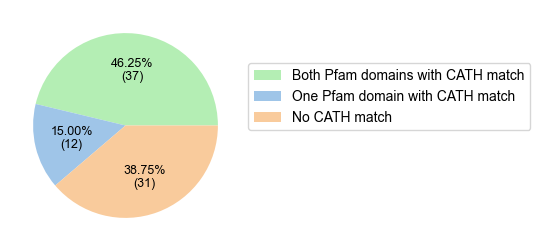

In [47]:
# Plot the distribution of DDIs in the manual curation set with 2, 1 and no CATH macthes for the two Pfam domains
my_pal = ['#b4eeb4', '#9fc5e8', '#f9cb9c'] #, '#ea9999', '#ffd966']

both = len(subset_both)
one = len(subset_one)
none = len(subset_none)

data = [both, one, none] # Sample data
labels = ['Both Pfam domains with CATH match', 'One Pfam domain with CATH match', 'No CATH match'] # Labels for each slice

my_autopct= make_autopct(data)
plt.figure(dpi=1200) 
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(data, colors = my_pal,autopct= my_autopct, textprops={'fontsize': 9})
ax.legend(labels= labels, bbox_to_anchor=(1, 0.8))
#plt.savefig(f'{save_path}', transparent=True, bbox_inches='tight')
plt.show()

In [49]:
# Filter for those DDI types with at least one CATH match on either of both Pfam domains
grouped_set_no_na = grouped_set[mask2]
grouped_set_no_na[['DomainID1', 'DomainID2', 'CATH_match_for_Pfam_domain1', 'CATH_match_for_Pfam_domain2']]

,DomainID1,DomainID2,CATH_match_for_Pfam_domain1,CATH_match_for_Pfam_domain2
DDI_type,,,,
PF00009_PF01873,PF00009,PF01873,"{No match, 3.40.50.300}",{3.30.70.3150}
PF00010_PF02344,PF00010,PF02344,{4.10.280.10},{4.10.280.10}
PF00019_PF00041,PF00019,PF00041,{2.10.90.10},"{No match, 2.60.40.10}"
PF00023_PF07686,PF00023,PF07686,{1.25.40.20},"{No match, 2.60.40.10}"
PF00023_PF09067,PF00023,PF09067,{1.25.40.20},"{No match, 2.60.40.10}"
PF00026_PF06394,PF00026,PF06394,{2.40.70.10},"{3.30.1120.50, No match}"
PF00059_PF00041,PF00059,PF00041,{3.10.100.10},"{No match, 2.60.40.10}"
PF00089_PF00095,PF00089,PF00095,{2.40.10.10},{4.10.75.10}
PF00149_PF00595,PF00149,PF00595,{3.60.21.10},{2.30.42.10}


In [50]:
# create a list of Pfams in the manual curation set that have at least one CATH match
l1 = []
l2 = []
for _, row in grouped_set_no_na.iterrows():
    if any(elem not in {np.nan, 'No match'} for elem in row['CATH_match_for_Pfam_domain1']):
        l1.append(row['DomainID1'])
    if any(elem not in {np.nan, 'No match'} for elem in row['CATH_match_for_Pfam_domain2']):
        l2.append(row['DomainID2'])

pfams = set(l1+l2)

In [51]:
len(pfams)

77

In [52]:
# Create a dataframe storing the CATH matches for each Pfam domain in the manual curation set

# Initialize an empty dictionary to store the sets of corresponding identifiers
identifier_sets = {}

# Iterate over each row in the dataframe
for index, row in grouped_set_no_na.iterrows():
    # Get the identifier from Column1 and Column2
    identifier1 = row['DomainID1']
    identifier2 = row['DomainID2']
    
    # Get the corresponding identifiers from Column3 and Column4
    identifiers3 = row['CATH_match_for_Pfam_domain1']
    identifiers4 = row['CATH_match_for_Pfam_domain2']
    
     # Add the identifiers to the sets in the dictionary
    if identifier1 not in identifier_sets:
        identifier_sets[identifier1] = identifiers3
    else:
        identifier_sets[identifier1].update(identifiers3)
        
    if identifier2 not in identifier_sets:
        identifier_sets[identifier2] = identifiers4
    else:
        identifier_sets[identifier2].update(identifiers4)

# Create a new dataframe from the dictionary
result_df = pd.DataFrame(identifier_sets.items(), columns=['Identifier', 'Corresponding Identifiers'])


In [53]:
result_df

,Identifier,Corresponding Identifiers
0,PF00009,"{No match, 3.40.50.300}"
1,PF01873,{3.30.70.3150}
2,PF00010,{4.10.280.10}
3,PF02344,{4.10.280.10}
4,PF00019,{2.10.90.10}
5,PF00041,"{No match, 2.60.40.10}"
6,PF00023,{1.25.40.20}
7,PF07686,"{No match, 2.60.40.10}"
8,PF09067,"{No match, 2.60.40.10}"
9,PF00026,{2.40.70.10}


In [54]:
# Filter out those Pfams that only have NaN or 'No match' for potential corresponding CATH identifiers

# Apply the filter function to each set in the 'Corresponding Identifiers' column
result_df['Corresponding Identifiers'] = result_df['Corresponding Identifiers'].apply(filter_nan_no_match)

# Filter out rows with empty sets in the 'Corresponding Identifiers' column
result_df = result_df[result_df['Corresponding Identifiers'].map(len) > 0]

In [55]:
len(result_df)

77

In [56]:
result_df= result_df.reset_index(drop=True)

In [57]:
result_df

,Identifier,Corresponding Identifiers
0,PF00009,{3.40.50.300}
1,PF01873,{3.30.70.3150}
2,PF00010,{4.10.280.10}
3,PF02344,{4.10.280.10}
4,PF00019,{2.10.90.10}
5,PF00041,{2.60.40.10}
6,PF00023,{1.25.40.20}
7,PF07686,{2.60.40.10}
8,PF09067,{2.60.40.10}
9,PF00026,{2.40.70.10}


In [58]:
## Get the number of CATH domains matching to multiple Pfam domains

# Initialize a dictionary to count occurrences of each identifier
identifier_counts = {}

# Iterate over the 'Corresponding Identifiers' column to count each identifier's occurrences
for identifiers in result_df['Corresponding Identifiers']:
    for identifier in identifiers:
        if identifier in identifier_counts:
            identifier_counts[identifier] += 1
        else:
            identifier_counts[identifier] = 1

# Find identifiers that appear in more than one row
multiple_occurrences = {identifier: count for identifier, count in identifier_counts.items() if count > 1}

# Get the count of such identifiers
num_multiple_occurrences = len(multiple_occurrences)


In [60]:
# Get the number of unique CATH domains mapped to Pfam domains in the manual curation set
CATH_set = set().union(*result_df['Corresponding Identifiers'])

In [62]:
CATH_set

{'1.10.10.580',
 '1.10.1060.10',
 '1.10.1070.11',
 '1.10.1090.10',
 '1.10.150.120',
 '1.10.20.10',
 '1.10.238.10',
 '1.10.565.10',
 '1.10.720.30',
 '1.10.840.10',
 '1.20.1020.10',
 '1.20.120.230',
 '1.20.1250.70',
 '1.20.190.20',
 '1.20.5.390',
 '1.20.5.620',
 '1.20.58.100',
 '1.20.81.10',
 '1.25.10.10',
 '1.25.40.20',
 '2.10.110.10',
 '2.10.90.10',
 '2.170.130.10',
 '2.30.29.210',
 '2.30.29.220',
 '2.30.29.30',
 '2.30.42.10',
 '2.40.10.10',
 '2.40.160.90',
 '2.40.70.10',
 '2.60.200.10',
 '2.60.40.10',
 '2.60.40.1490',
 '2.60.40.640',
 '2.60.40.780',
 '3.10.100.10',
 '3.10.110.10',
 '3.10.20.30',
 '3.20.80.10',
 '3.30.1120.50',
 '3.30.1370.10',
 '3.30.1520.10',
 '3.30.2420.10',
 '3.30.310.230',
 '3.30.310.80',
 '3.30.40.10',
 '3.30.420.40',
 '3.30.450.190',
 '3.30.470.20',
 '3.30.505.10',
 '3.30.70.3150',
 '3.30.710.10',
 '3.30.830.10',
 '3.40.190.10',
 '3.40.50.300',
 '3.50.50.60',
 '3.60.21.10',
 '3.70.10.10',
 '3.90.1170.50',
 '3.90.280.10',
 '3.90.700.10',
 '4.10.280.10',
 '4.10.72

In [63]:
# Create a dictionary that stores subsets of the CATH domains CATH_set belonging to the same CATH architecture

# Initialize a dictionary to store subsets
subsets = {}

# Iterate over each element in the set
for elem in CATH_set:
    # Split the element into parts based on dots ('.')
    parts = elem.split('.')
    
    # Extract the first and second numbers between the dots
    key = (parts[0] + '.' + parts[1])
    
    # Add the element to the corresponding subset in the dictionary
    if key not in subsets:
        subsets[key] = {elem}
    else:
        subsets[key].add(elem)

print(subsets)

{'1.25': {'1.25.10.10', '1.25.40.20'}, '2.10': {'2.10.110.10', '2.10.90.10'}, '2.60': {'2.60.40.640', '2.60.40.780', '2.60.200.10', '2.60.40.1490', '2.60.40.10'}, '3.90': {'3.90.280.10', '3.90.700.10', '3.90.1170.50'}, '3.10': {'3.10.100.10', '3.10.20.30', '3.10.110.10'}, '1.10': {'1.10.1070.11', '1.10.238.10', '1.10.20.10', '1.10.10.580', '1.10.840.10', '1.10.1090.10', '1.10.1060.10', '1.10.150.120', '1.10.720.30', '1.10.565.10'}, '3.70': {'3.70.10.10'}, '3.30': {'3.30.2420.10', '3.30.710.10', '3.30.450.190', '3.30.310.80', '3.30.40.10', '3.30.70.3150', '3.30.310.230', '3.30.505.10', '3.30.1370.10', '3.30.830.10', '3.30.470.20', '3.30.1120.50', '3.30.420.40', '3.30.1520.10'}, '4.10': {'4.10.75.10', '4.10.720.10', '4.10.280.10'}, '3.40': {'3.40.50.300', '3.40.190.10'}, '2.30': {'2.30.42.10', '2.30.29.30', '2.30.29.210', '2.30.29.220'}, '3.60': {'3.60.21.10'}, '3.50': {'3.50.50.60'}, '2.40': {'2.40.10.10', '2.40.160.90', '2.40.70.10'}, '1.20': {'1.20.5.620', '1.20.58.100', '1.20.81.10',

In [64]:
# Create a dictionary storing the number of detected CATH domains for a given CATH architecture
subsets_counts = {}
for key, val in subsets.items():
    subsets_counts[key] = len(val)
subsets_counts_sorted = {k: subsets_counts[k] for k in sorted(subsets_counts)}
subsets_counts_sorted

In [67]:
# Number of different CATH architectures detected in the manual curation set
len(subsets_counts_sorted)

19

<Figure size 7680x5760 with 0 Axes>

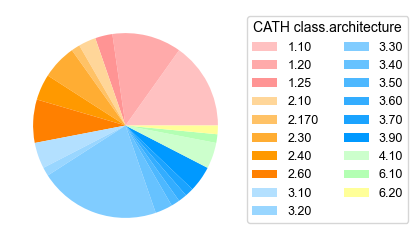

In [74]:
# Plot the distribution of CATH classes and architectures detected in the manual curation set

my_pal = ['#FFC1C1', '#FFAAAA', '#FF9494', '#FFD699', '#FFC266', '#FFAD33', '#FF9900', '#FF8000', '#B3E0FF', '#99D6FF',
         '#80CCFF', '#66C2FF', '#4DB8FF', '#33ADFF', '#1AA3FF', '#0099FF', '#CCFFCC', '#B3FFB3', '#FFFF99']

both = len(subset_both)
one = len(subset_one)
none = len(subset_none)

data = subsets_counts_sorted.values() # Sample data
labels = subsets_counts_sorted.keys() # Labels for each slice

my_autopct= make_autopct(data)
plt.figure(dpi=1200) 
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(data, colors = my_pal, textprops={'fontsize': 9}) #, wedgeprops=dict(edgecolor='black')
ax.legend(labels= labels, bbox_to_anchor=(1, 1), title= 'CATH class.architecture', ncol=2, fontsize=9)

# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=my_pal[i], markersize=10, label=label) for i, label in enumerate(labels)]

# # Add the custom legend
# plt.legend(handles=legend_elements, title='CATH class.architecture', loc='upper right', bbox_to_anchor=(2, 1))


#plt.savefig(f'{save_path}CATH_classes_architectures_of_matching_CATH_domains_in_the_manual_curation_set.pdf', transparent=True, bbox_inches='tight')
plt.show()